In [1]:
import pandas as pd
import numpy as np
import itertools as it
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
%matplotlib inline

# Preliminaries, make variables for plotting and labels

In [2]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
month_abbrev = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
                '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-08-01'

alldates = pd.date_range(start=start, end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values, list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

# Load data from google sheets
https://docs.google.com/spreadsheets/d/1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/edit#gid=0

In [3]:
# get school names, abbreviations, colors, etc.
school_deets = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                           '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=refs')

In [4]:
keep_ipeds = school_deets.loc[school_deets['data']=='yes']['name'].values

In [5]:
# span through each google sheet and append it to a single dataframe
badd = []
mout = []
for b in keep_ipeds:
    burl = b.replace(" ",'%20')
    try:
        mass_d = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                               '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=%s'%burl)
        mass_d = mass_d[['date','total_tests','positive_tests','college','url','ipeds_id']].copy()
        deets_d = school_deets.loc[school_deets['ipeds_id']==mass_d['ipeds_id'].values[0]].copy()

        mass_dx = DATE_DF.copy()
        mass_dx['university'] = mass_d['college'].dropna().unique()[0]
        mass_dx['enrollment'] = deets_d['enrollment'].dropna().unique()[0]
        mass_dx['url'] = mass_d['url'].dropna().unique()[0]
        mass_dx = mass_dx.merge(mass_d[['date','total_tests','positive_tests']],how='left',on='date')
        mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
        mass_dx['positive_tests'] = np.nan_to_num(mass_dx['positive_tests'])
        mass_dx['total_tests'] = mass_dx['total_tests'].astype(str).str.replace(',','').astype(float)
        mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
        mass_d = mass_dx.loc[(mass_dx['date']<=today)&(mass_dx['date']>=start)].copy()
        mout.append(mass_d)
    except:
        print("something's up with",b)
        badd.append(b)

for b in badd:
    burl = b.replace(" ",'%20')
    try:
        mass_d = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                               '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=%s'%burl)
        mass_d = mass_d[['date','total_tests','positive_tests','college','url','ipeds_id']].copy()
        deets_d = school_deets.loc[school_deets['ipeds_id']==mass_d['ipeds_id'].values[0]].copy()

        mass_dx = DATE_DF.copy()
        mass_dx['university'] = mass_d['college'].dropna().unique()[0]
        mass_dx['enrollment'] = deets_d['enrollment'].dropna().unique()[0]
        mass_dx['url'] = mass_d['url'].dropna().unique()[0]
        mass_dx = mass_dx.merge(mass_d[['date','total_tests','positive_tests']],how='left',on='date')
        mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
        mass_dx['positive_tests'] = np.nan_to_num(mass_dx['positive_tests'])
        mass_dx['total_tests'] = mass_dx['total_tests'].astype(str).str.replace(',','').astype(float)
        mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
        mass_d = mass_dx.loc[(mass_dx['date']<=today)&(mass_dx['date']>=start)].copy()
        mout.append(mass_d)
    except:
        print("\tsomething's still up with",b)
        badd.append(b)

mass_data = pd.concat(mout).reset_index().iloc[:,1:]
mass_g = mass_data.groupby(['week','university','enrollment']).agg({
                            'date':'min','total_tests':'sum','positive_tests':'sum'}).reset_index()

In [6]:
mass_data.to_csv('../data/massachusetts_ihe_data.csv',index=False)

# Plot a big jumble of case counts over time

In [7]:
statewide_df = mass_data.groupby('date').agg({'enrollment':'sum',
                                              'total_tests':'sum',
                                              'positive_tests':'sum'}).reset_index()

In [8]:
sorder = mass_data.groupby('university').agg({'positive_tests':'sum'}
                                            ).reset_index().sort_values('positive_tests',ascending=False)
sorder = sorder['university'].values[:64]

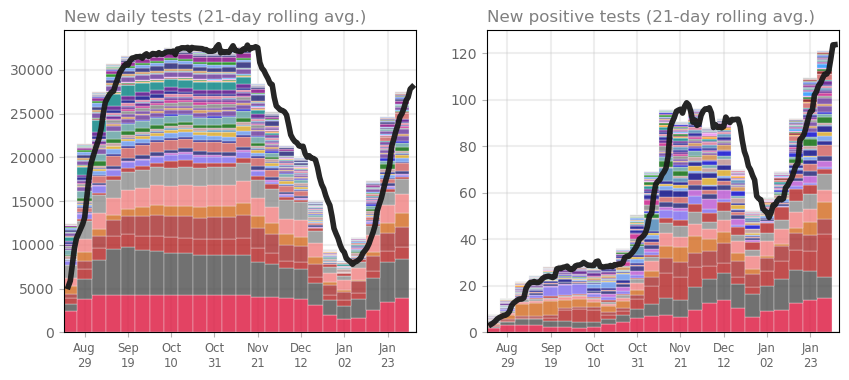

In [9]:
wid = 21
lw = 4
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=100)

xvals_u = np.array([date_dict[i] for i in statewide_df['date'].values])
yvalr_u = statewide_df['total_tests'].rolling(window=wid).mean().values
ax[0].plot(xvals_u[:-1], yvalr_u[:-1], color='.1', linewidth=lw, alpha=0.95)

yvals_cases = np.zeros(mass_g.loc[mass_g['date']>start]['date'].nunique())
yvals_tests = np.zeros(mass_g.loc[mass_g['date']>start]['date'].nunique())
for i, univ in enumerate(sorder):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = mass_g.loc[(mass_g['university']==univ)&(mass_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].rolling(window=3).mean().values/7    
    ax[1].bar(xvals_u, yvals_u, bottom=yvals_cases, fc=univ_col, alpha=0.8, ec='.95', lw=0.3, width=7)
    yvals_cases = np.nan_to_num(yvals_cases+yvals_u)

    yvals_u = data_u['total_tests'].rolling(window=3).mean().values/7    
    ax[0].bar(xvals_u, yvals_u, bottom=yvals_tests, fc=univ_col, alpha=0.8, ec='.95', lw=0.3, width=7)
    yvals_tests = np.nan_to_num(yvals_tests+yvals_u)


xvals_u = np.array([date_dict[i] for i in statewide_df['date'].values])
yvalr_u = statewide_df['positive_tests'].rolling(window=wid).mean().values
ax[1].plot(xvals_u[:-1], yvalr_u[:-1], color='.1', linewidth=lw, alpha=0.95)

date_labs = statewide_df['date'].values[7::21]
ax[0].set_title("New daily tests (%i-day rolling avg.)"%(wid), x=0, ha='left', color='.5')
ax[1].set_title("New positive tests (%i-day rolling avg.)"%(wid), x=0, ha='left', color='.5')

for a in fig.axes:
    a.set_xticks([date_dict[i] for i in date_labs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in date_labs],fontsize='small')

    a.set_xlim(date_dict['2020-08-19'], date_dict[today]+1)
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')

plt.savefig('../figs/pngs/ma_ihe_statewide.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_ihe_statewide.pdf', bbox_inches='tight')

plt.show()

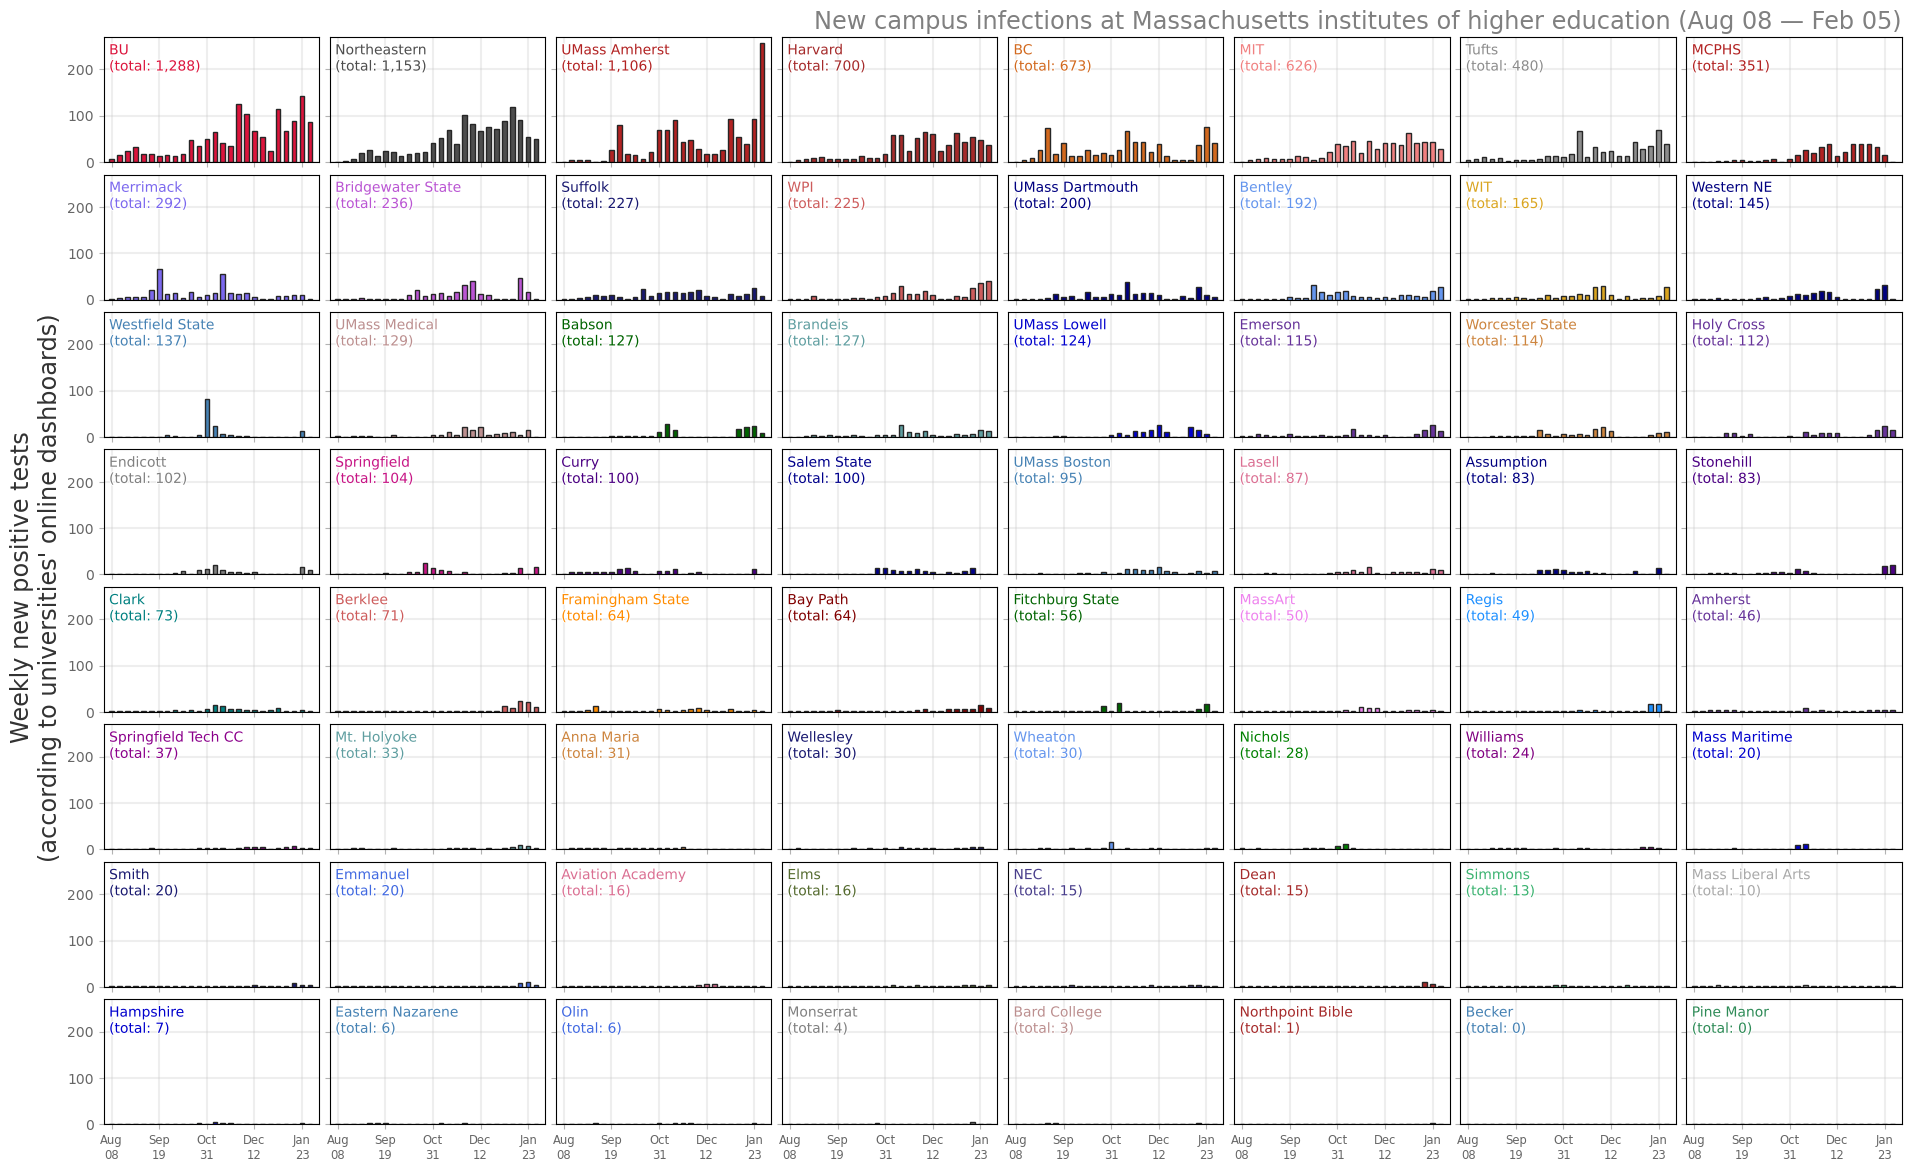

In [10]:
w = 2.9; h = 1.8
ncols = 8; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(sorder[-len(tups):]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = mass_g.loc[(mass_g['university']==univ)&(mass_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].values+1
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)

    name = univ_abb + '\n(total: %s)'%("{:,}".format(tot_cases))
    ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

ax[(int(nrows/2),0)].set_ylabel("Weekly new positive tests\n(according to universities' online dashboards)",
                     color='.2',fontsize='xx-large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Massachusetts institutes of higher education (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5',fontsize='xx-large')

for a in fig.axes:
    datlabs = data_u['date'].unique()[::6]
    a.set_xticks([date_dict[i] for i in datlabs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    
    a.set_ylim(0, mass_g['positive_tests'].max()*1.05)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict[start], date_dict[today]+2)


plt.savefig('../figs/pngs/ma_ihe_statewide_grid.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_ihe_statewide_grid.pdf', bbox_inches='tight')

plt.show()

In [11]:
sorder2 = ['Boston University', 'Northeastern University',
       'University of Massachusetts-Amherst', 'Harvard University',
       'Boston College', 'Massachusetts Institute of Technology',
       'Tufts University', 'Merrimack College',
       'Bridgewater State University', 'Suffolk University',
       'Worcester Polytechnic Institute',
       'University of Massachusetts-Dartmouth', 'Bentley University',
       'Wentworth Institute of Technology',
       'Western New England University', 'Westfield State University',
       'Babson College', 'University of Massachusetts-Lowell',
       'Brandeis University', 'Emerson College',
       'College of the Holy Cross', 'Worcester State University',
       'Curry College', 'Salem State University', 'Endicott College',
       'University of Massachusetts-Boston', 'Springfield College',
       'Assumption College', 'Lasell University', 'Clark University',
       'Berklee College of Music', 'Framingham State University',
       'Bay Path University', 'Stonehill College',
       'Fitchburg State University',
       'Massachusetts College of Art and Design', 'Regis College',
       'Amherst College', 'Springfield Technical Community College',
       'Mount Holyoke College', 'Nichols College',
       'Wheaton College', 'Wellesley College', 'Williams College',
       'Smith College', 'Emmanuel College', 'Dean College', 'The New England Conservatory of Music',
       'College of Our Lady of the Elms', 'Simmons University',
       'Massachusetts College of Liberal Arts', 'Hampshire College',
       'Eastern Nazarene College',
       'Franklin W Olin College of Engineering',
       'Montserrat College of Art', "Bard College at Simon's Rock"]

max_pers = {'name':[],'total_cases_per_1000':[]}
for i, univ in enumerate(sorder2[-len(tups):]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = mass_g.loc[(mass_g['university']==univ)&(mass_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].values
    yvals_u = yvals_u / data_u['enrollment'] * 1000
    max_pers['name'].append(univ)
    max_pers['total_cases_per_1000'].append(sum(yvals_u))
    
sorder2 = pd.DataFrame(max_pers).sort_values('total_cases_per_1000',ascending=False)['name'].values

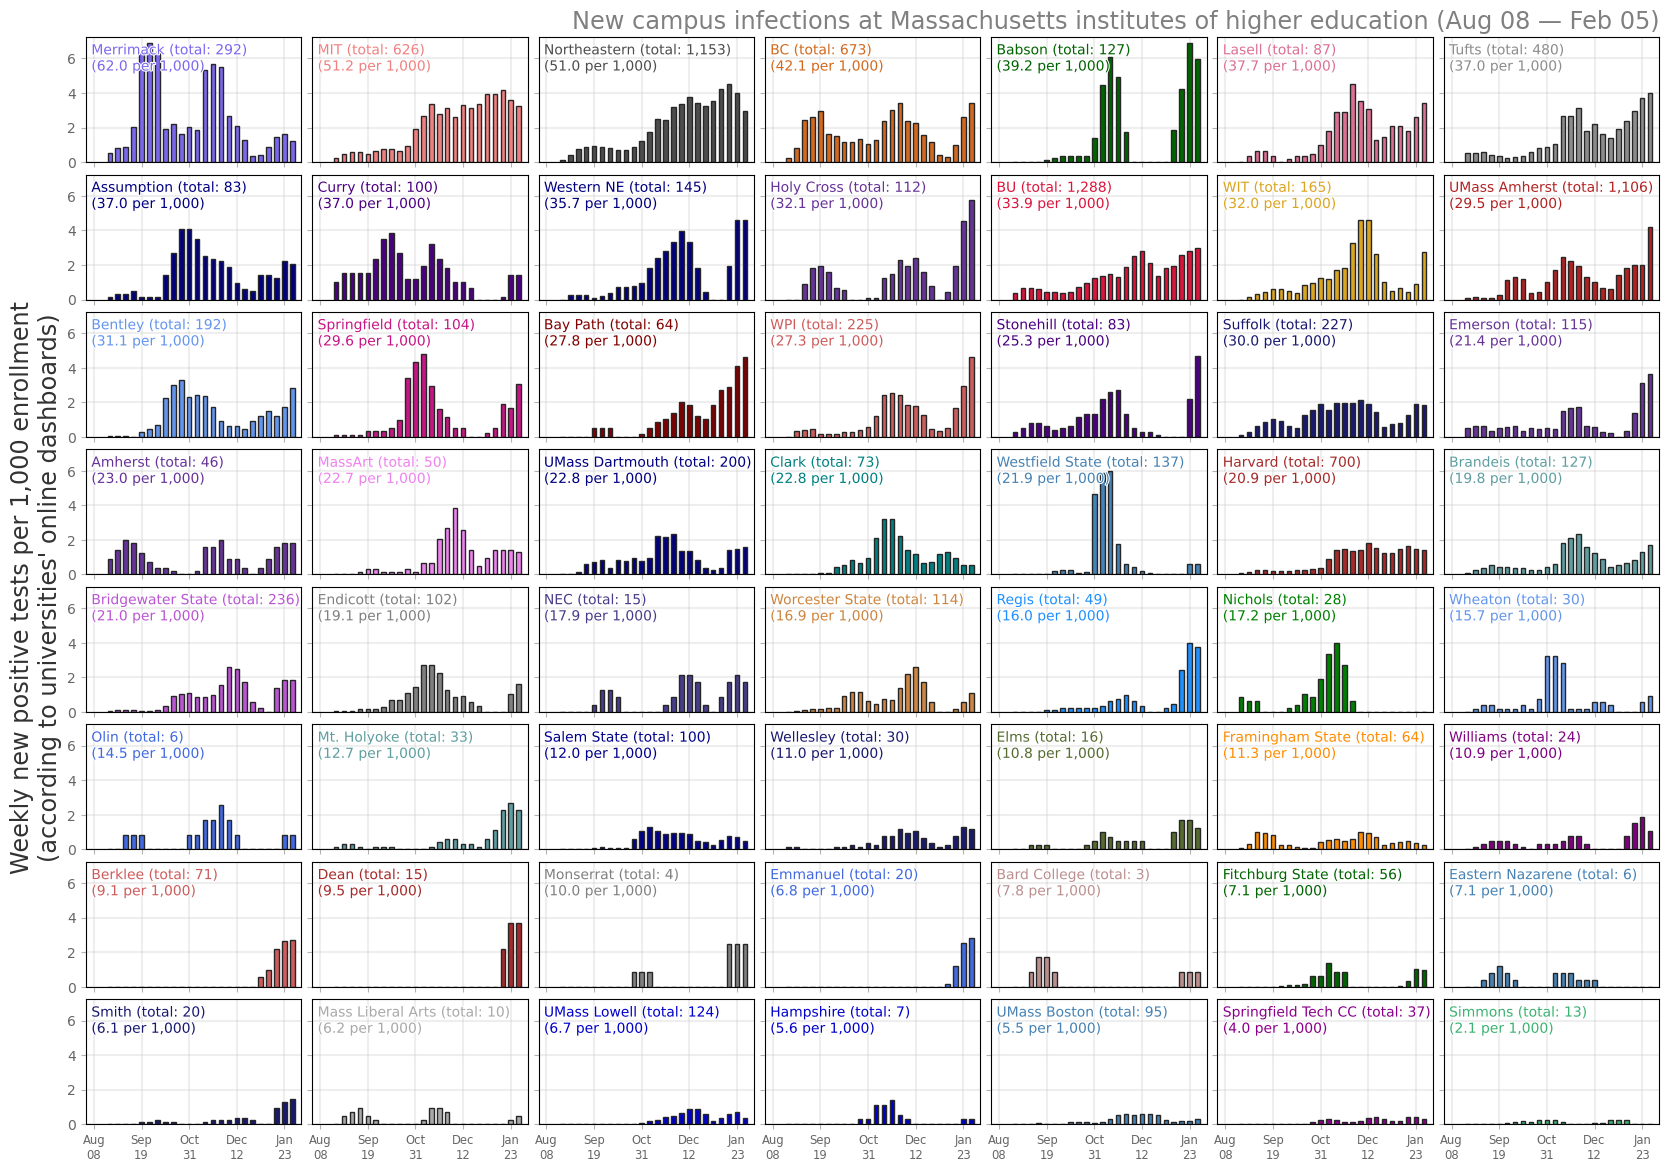

In [12]:
w = 2.9; h = 1.8
ncols = 7; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(sorder2[-len(tups):]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = mass_g.loc[(mass_g['university']==univ)&(mass_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].rolling(window=3).mean().values
    yvals_u = yvals_u / data_u['enrollment'] * 1000
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)

    name = univ_abb + ' (total: %s)\n(%.1f per 1,000)'%("{:,}".format(tot_cases),np.nansum(yvals_u))
    ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

ax[(int(nrows/2),0)].set_ylabel("Weekly new positive tests per 1,000 enrollment"+\
                                "\n(according to universities' online dashboards)",
                     color='.2',fontsize='xx-large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Massachusetts institutes of higher education (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5', fontsize='xx-large')

for a in fig.axes:
    datlabs = data_u['date'].unique()[::6]
    a.set_xticks([date_dict[i] for i in datlabs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict[start], date_dict[today]+2)


plt.savefig('../figs/pngs/ma_ihe_statewide_grid_per1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_ihe_statewide_grid_per1000.pdf', bbox_inches='tight')

plt.show()

In [13]:
torder = mass_data.groupby('university').agg({'total_tests':'sum','enrollment':'mean'}).reset_index()
torder['test_per'] = torder['total_tests'] / torder['enrollment']
torder = torder.sort_values('test_per',ascending=False)['university'].values[:64]

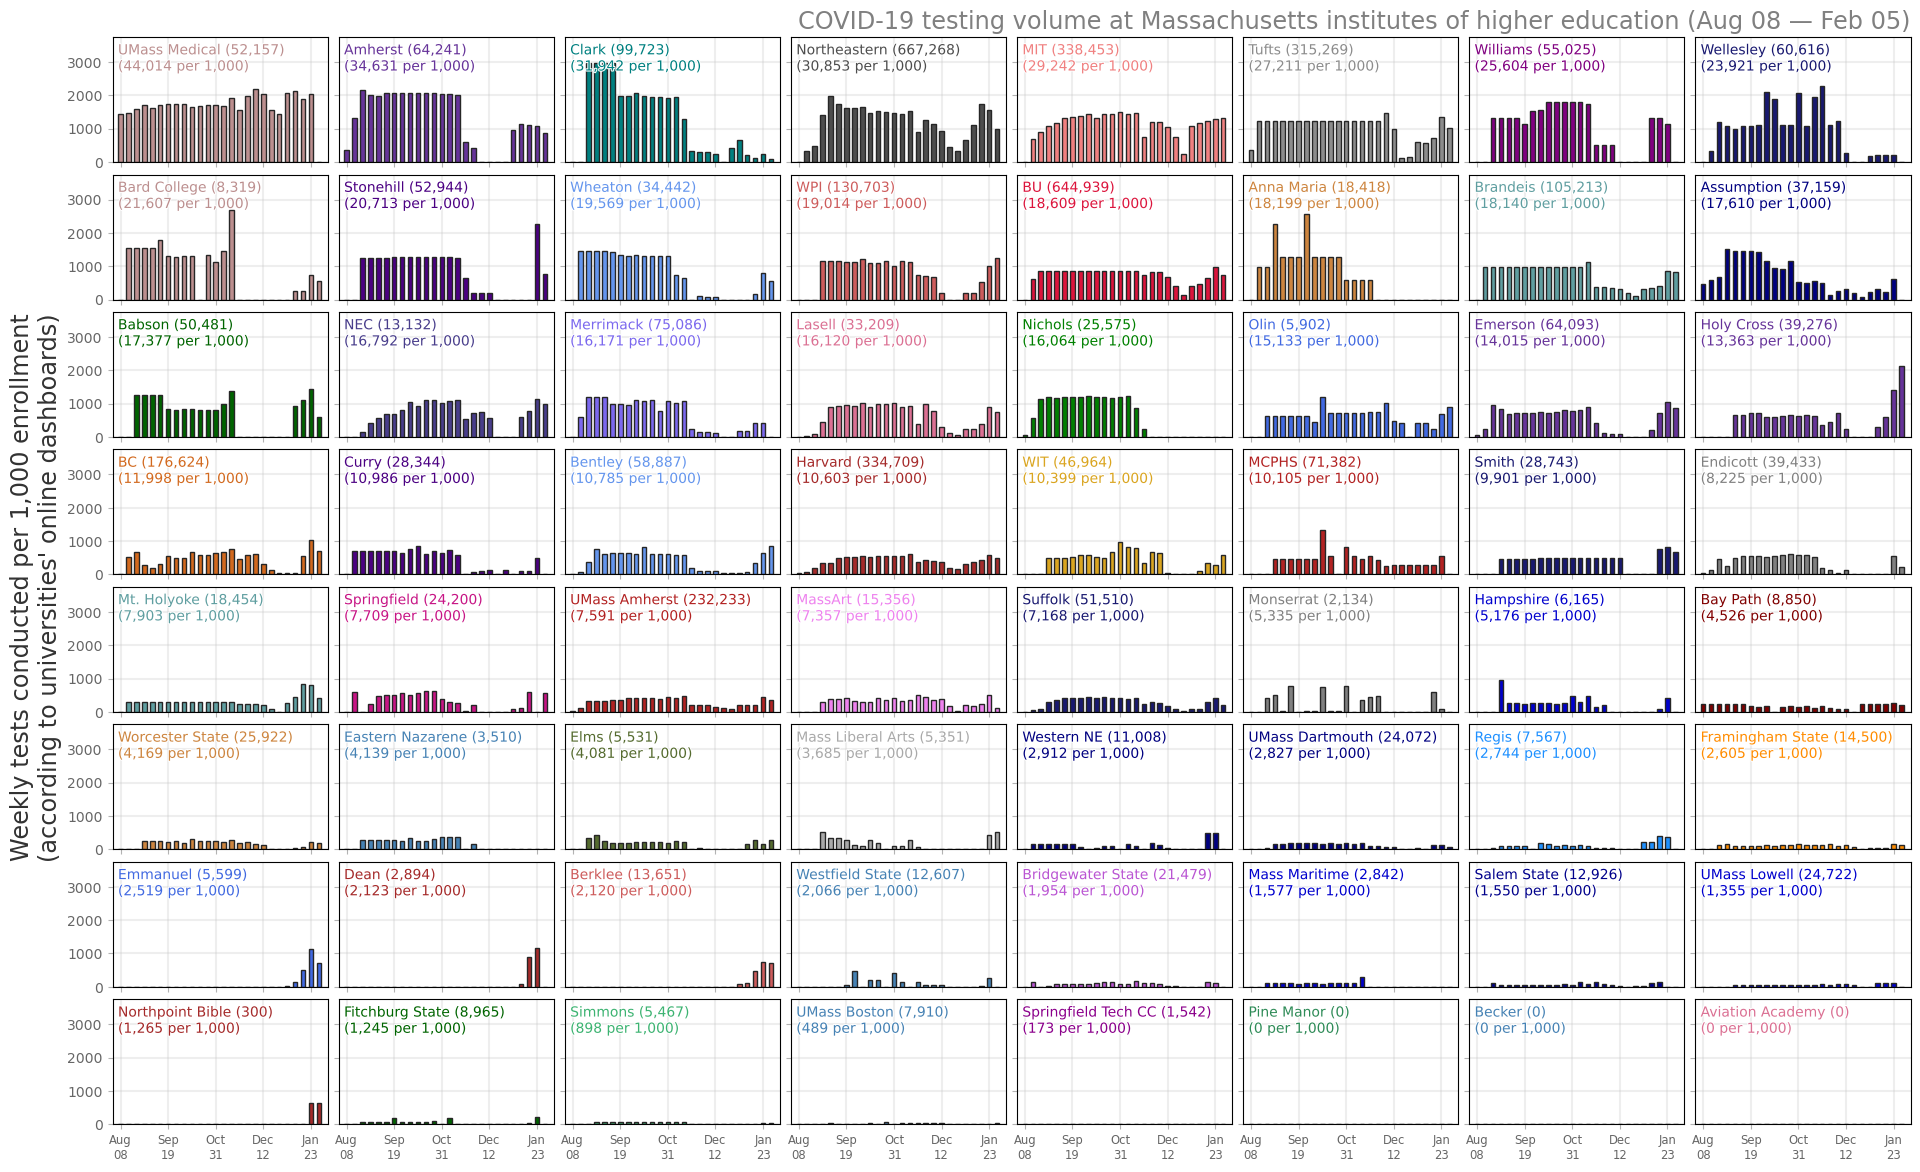

In [14]:
w = 2.9; h = 1.8
ncols = 8; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(torder[-len(tups):]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = mass_g.loc[(mass_g['university']==univ)&(mass_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['total_tests'].values))
    yvals_u = data_u['total_tests'].values
    yvals_u = yvals_u / data_u['enrollment'] * 1000
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)

    name = univ_abb + ' (%s)\n(%s per 1,000)'%("{:,}".format(tot_cases), "{:,}".format(int(sum(yvals_u))))
    ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

ax[(int(nrows/2),0)].set_ylabel("Weekly tests conducted per 1,000 enrollment"+\
                                "\n(according to universities' online dashboards)",
                     color='.2',fontsize='xx-large', y=1)
ax[(0,ncols-1)].set_title("COVID-19 testing volume at Massachusetts institutes of higher education (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5', fontsize='xx-large')

for a in fig.axes:
    datlabs = data_u['date'].unique()[::6]
    a.set_xticks([date_dict[i] for i in datlabs])
    a.set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in datlabs],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict[start], date_dict[today]+2)
    a.set_ylim(0,3750)


plt.savefig('../figs/pngs/ma_ihe_statewide_tests_grid_per1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_ihe_statewide_tests_grid_per1000.pdf', bbox_inches='tight')

plt.show()